In [1]:
%pylab inline 
df = redshift_query("""
WITH 
       shop_assignments AS (
           SELECT
             ea._shop_key as _shop_key,
             g."experiment group name" as group,
             ea."Event Timestamp" as assigned_at
           FROM
             (
             SELECT _experiment_group_key, _shop_key, "Event Timestamp" FROM experiments.support_chat_experiment_event_facts s 
              UNION
             SELECT _experiment_group_key, _shop_key, "Event Timestamp" FROM experiments.docs_experiment_event_facts d
              UNION
             SELECT _experiment_group_key, _shop_key, "Event Timestamp" FROM experiments.shop_experiment_event_facts sc 
             ) ea
           JOIN
             experiments.experiment_group_dimension g
           ON g._experiment_group_key = ea._experiment_group_key
             AND g."experiment name" = 'queue_messages'
           WHERE ea._shop_key NOT IN (-1, -2)
       )
   
       SELECT
         shop_assignments.group,
         SUM(CASE WHEN ratings.rating='Smile' then 1 ELSE 0 END) as conversions,
         COUNT(1) as total
       FROM shop_assignments
       JOIN support.smileys_facts
          ON shop_assignments._shop_key = smileys_facts._shop_key
          and shop_assignments.assigned_at > smileys_facts."smiley comment at"
       JOIN support.smileys_profile_dimension ratings
          ON ratings._smileys_profile_key = smileys_facts._smileys_profile_key
       GROUP BY 1
""")

In [2]:
df

,Group,Conversions,Total
0,control,9377,10330
1,queue_messages,9633,10609


In [3]:
9377./10330 Binomial(N, p)

0.9077444336882865

In [10]:
from scipy.stats import beta

In [37]:
N = 10330 
X = 9377 
x= np.linspace(0,1,1000)
y = beta(1+X,1+N-X).pdf(x)


N_2 = 10609 
X_2 = 9563 
y_2 = beta(1+X_2,1+N_2-X_2).pdf(x)

(0.85, 0.95)

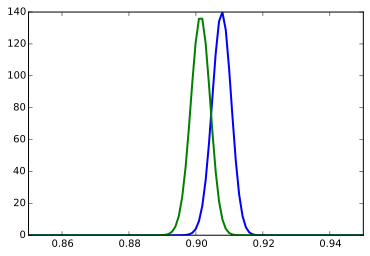

In [38]:
plot(x,y)
plot(x,y_2)

plt.xlim(0.85,.95)

In [39]:
X ~ Binomial(N, p), prior = Beta(alpha, beta), posterior = Beta(alpha + X, beta + N - X)

SyntaxError: invalid syntax (<ipython-input-39-1b347fc20b18>, line 1)

In [40]:
samples_1 =  beta(1+X,1+N-X).rvs(10000)
samples_2 =  beta(1+X_2,1+N_2-X_2).rvs(10000)


(array([    7.,    64.,   322.,  1100.,  2334.,  2869.,  2119.,   933.,
          227.,    25.]),
 array([ 0.89626852,  0.89838437,  0.90050022,  0.90261607,  0.90473192,
         0.90684777,  0.90896363,  0.91107948,  0.91319533,  0.91531118,
         0.91742703]),
 <a list of 10 Patch objects>)

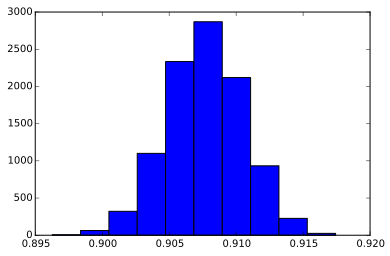

In [45]:
(samples_1 > samples_2).mean()

0.94430000000000003

In [55]:
(samples_1 - samples_2)/samples_2

array([ 0.0112911 ,  0.00523598,  0.0075068 , ...,  0.00608401,
        0.00278266,  0.01009266])

(array([   1.,    1.,    1.,    3.,    2.,    1.,    8.,    5.,    5.,
          19.,   26.,   43.,   52.,   83.,  104.,  134.,  210.,  235.,
         282.,  322.,  365.,  450.,  464.,  506.,  571.,  607.,  611.,
         580.,  577.,  509.,  503.,  496.,  439.,  365.,  314.,  253.,
         221.,  161.,  132.,  100.,   74.,   57.,   29.,   26.,   18.,
          18.,    5.,    2.,    4.,    6.]),
 array([-0.01109481, -0.01041774, -0.00974068, -0.00906362, -0.00838655,
        -0.00770949, -0.00703243, -0.00635537, -0.0056783 , -0.00500124,
        -0.00432418, -0.00364711, -0.00297005, -0.00229299, -0.00161593,
        -0.00093886, -0.0002618 ,  0.00041526,  0.00109233,  0.00176939,
         0.00244645,  0.00312351,  0.00380058,  0.00447764,  0.0051547 ,
         0.00583177,  0.00650883,  0.00718589,  0.00786295,  0.00854002,
         0.00921708,  0.00989414,  0.01057121,  0.01124827,  0.01192533,
         0.01260239,  0.01327946,  0.01395652,  0.01463358,  0.01531065,
         0.01598

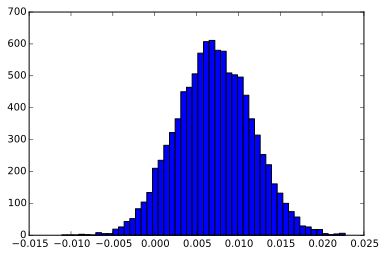

In [56]:
hist(_, bins=50)

In [61]:
np.percentile(((samples_1 - samples_2)/samples_2), 50)

0.0070705673651868381

0.011111111111111112

In [62]:
df

,Group,Conversions,Total
0,control,9377,10330
1,queue_messages,9633,10609


In [ ]:
from scipy.stats import beta

def conversion_analysis(df):
    df = df.set_index('group')
    beta_prior = alpha_prior = 1
    N = 10000

    df['posterior'] = df.applymap(lambda r: beta(r['conversions'] + alpha_prior, r['total'] - r['conversions'] + beta_prior), axis=1)
        
    results = pd.DataFrame(index=pd.MultiIndex.from_product([df.index, df.index]), columns['p_conversion', 'lift'])
    for group_1, group_2 in results.index:
        samples_1 = df.ix[group_1]['posterior'].rvs(N)
        samples_2 = df.ix[group_2]['posterior'].rvs(N)
        results.ix[group_1, group_2]['p_conversion'] = (samples_1 > samples_2).mean()
        results.ix[group_1, group_2]['lift'] = np.percentile(((samples_1 - samples_2)/samples_2), 35)
    
    return results

    

    
    

In [64]:
df.itertuples().next()

(0, 'control', 9377, 10330)

In [68]:
df = df.set_index('Group')

In [78]:
from itertools import product

In [88]:
i = product(df.index, df.index)

In [92]:
i.next()

('queue_messages', 'queue_messages')

In [87]:
i.next()

StopIteration: 

In [93]:
    results = pd.DataFrame(index=product(df.index, df.index))


In [105]:
    results = pd.DataFrame([np.arange(4), np.arange(4)], index=pd.MultiIndex.from_product([df.index, df.index]))


ValueError: Shape of passed values is (4, 2), indices imply (4, 4)

In [107]:
for _ in results.index:
    print _

('control', 'control')
('control', 'queue_messages')
('queue_messages', 'control')
('queue_messages', 'queue_messages')
